Vamos a meter el nivel de torneo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from ranking_scores import puntos_ranking

In [2]:
def calculate_head_to_head(dataset):
    # Convertir la columna 'tourney_date' a formato de fecha
    dataset['tourney_date'] = pd.to_datetime(dataset['tourney_date'], format='%Y%m%d')

    # Ordenar el dataset por fecha
    dataset = dataset.sort_values('tourney_date')

    # Inicializar una nueva columna para el historial de enfrentamientos directos
    dataset['head_to_head'] = 0.5
    '''dataset['num_matches'] = 0'''
    # Iterar sobre las filas del dataset
    for index, row in dataset.iterrows():
        # Obtener los partidos anteriores entre los dos jugadores
        previous_matches = dataset[((dataset['winner_id'] == row['winner_id']) & (dataset['loser_id'] == row['loser_id']) | (dataset['winner_id'] == row['loser_id']) & (dataset['loser_id'] == row['winner_id'])) & (dataset['tourney_date'] < row['tourney_date'])]

        if not previous_matches.empty:
            # Calcular el porcentaje de veces que el 'winner_id' ha ganado
            wins = len(previous_matches[previous_matches['winner_id'] == row['winner_id']])
            total = len(previous_matches)
            dataset.at[index, 'head_to_head'] = wins / total
            '''# Calcular el número de partidos jugados
            dataset.at[index, 'num_matches'] = total'''

    return dataset

In [13]:
# Cargar los datos de los años
data_2021 = pd.read_csv('atp_matches_2021.csv')
data_2022 = pd.read_csv('atp_matches_2022.csv')
data_2023 = pd.read_csv('atp_matches_2023.csv')

# Agregar una columna 'source' a cada DataFrame
data_2021['source'] = 'atp_matches_2021.csv'
data_2022['source'] = 'atp_matches_2022.csv'
data_2023['source'] = 'atp_matches_2023.csv'

# Combinar los datos en un solo DataFrame
data_all = pd.concat([data_2021, data_2022, data_2023])

# Aplicar la función calculate_head_to_head
data_all = calculate_head_to_head(data_all)

# Filtrar los datos para obtener solo los partidos de 2023 del archivo 'atp_matches_2023.csv'
dataset = data_all[data_all['source'] == 'atp_matches_2023.csv']

In [14]:
tenistas = pd.concat([dataset['winner_id'], dataset['loser_id']])
tenistas = set(tenistas)
num_tenistas = len(tenistas)

In [15]:
dataset_r = pd.read_csv('atp_rankings_20s.csv')

### Realizamos el tratamiento de los NaN's antes de nada

In [16]:
# Encontramos el valor más común entre 'Grass', 'Hard', y 'Clay'
most_common = dataset[dataset['surface'].isin(['Grass', 'Hard', 'Clay'])]['surface'].mode()[0]

# Reemplazamos los valores que no son 'Grass', 'Hard', o 'Clay' (los NaN's) con el valor más común
dataset.loc[~dataset['surface'].isin(['Grass', 'Hard', 'Clay']), 'surface'] = most_common

In [17]:
pk = puntos_ranking(dataset, dataset_r, 2023)

c:\Users\Guille\OneDrive\Escritorio\Deepty Projects\ranking_scores.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['tourney_date'] = pd.to_datetime(dataset['tourney_date'], format='%Y%m%d')
c:\Users\Guille\OneDrive\Escritorio\Deepty Projects\ranking_scores.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['year_month'] = dataset['tourney_date'].dt.to_period('M')


In [18]:
dataset.loc[:, 'winner_rank_points'], dataset.loc[:, 'loser_rank_points'] = pk['winner_points'], pk['loser_points']

In [19]:
dataset.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,source,head_to_head,year_month
69,2023-2843,Adelaide 1,Hard,32,A,2023-01-02,279,207733,NaN,NaN,...,8.0,7.0,12.0,42.0,990.0,83.0,630.0,atp_matches_2023.csv,0.5,2023-01
70,2023-2843,Adelaide 1,Hard,32,A,2023-01-02,278,111575,8.0,NaN,...,9.0,8.0,12.0,20.0,1990.0,57.0,813.0,atp_matches_2023.csv,0.5,2023-01
71,2023-2843,Adelaide 1,Hard,32,A,2023-01-02,277,206173,6.0,NaN,...,8.0,1.0,4.0,15.0,2410.0,582.0,52.0,atp_matches_2023.csv,1.0,2023-01
72,2023-2843,Adelaide 1,Hard,32,A,2023-01-02,276,106423,NaN,WC,...,12.0,5.0,6.0,93.0,592.0,34.0,1163.0,atp_matches_2023.csv,0.5,2023-01
76,2023-2843,Adelaide 1,Hard,32,A,2023-01-02,272,111456,NaN,NaN,...,5.0,0.0,2.0,63.0,775.0,67.0,741.0,atp_matches_2023.csv,0.5,2023-01


In [20]:
'''Indice 7: ganador del partido.
Indice 15: perdedor del partido.
Indice -1: puntos en el ranking del jugador ganador
Indice -3: puntos en el ranking del jugador perdedor
Indice 2: tipo de campo del partido (grass, hard o clay)'''
'''X = dataset.iloc[:, [7, 15, -1, -3, 2]].values
y = dataset.iloc[:, 7].values'''

'X = dataset.iloc[:, [7, 15, -1, -3, 2]].values\ny = dataset.iloc[:, 7].values'

In [25]:
columnas_X = ['winner_id', 'loser_id', 'winner_rank_points', 'loser_rank_points', 'head_to_head', 'tourney_level', 'surface']
columna_y = 'winner_id'
X = dataset[columnas_X].values
y = np.zeros(X.shape[0])

In [26]:
X[:, 0] = X[:, 0].astype(str)
X[:, 1] = X[:, 1].astype(str)

In [27]:
# Crear el codificador
encoder = OneHotEncoder(sparse_output=False)

# Ajustar el codificador con los datos de ambos jugadores y 'y'
encoder.fit(X[:, [0, 1]].reshape(-1, 1))

# Transformar las columnas de los jugadores
player1_onehot = encoder.transform(X[:, 0].reshape(-1, 1))
player2_onehot = encoder.transform(X[:, 1].reshape(-1, 1))


# Concatenar las columnas one-hot con el resto de tus datos
X = np.concatenate([player1_onehot[:, :-1], player2_onehot[:, :-1], X[:, 2:]], axis=1)


In [28]:
# Matriz de booleanos aleatorios del mismo tamaño que tus datos
swap = np.random.rand(len(X)) > 0.5

# Intercambiamos las posiciones de los jugadores en 'X' donde 'swap' es True
X[swap, :num_tenistas-1], X[swap, num_tenistas-1:num_tenistas*2-2] = X[swap, num_tenistas-1:num_tenistas*2-2], X[swap, :num_tenistas-1].copy()

# Intercambiamos las posiciones de los puntos en el ranking donde 'swap' es True
X[swap, num_tenistas*2-2], X[swap, num_tenistas*2+1-2] = X[swap, num_tenistas*2+1-2], X[swap, num_tenistas*2-2].copy()

mask = (swap) & (X[:, -3] != -1)
X[mask, -3] = 1 - X[mask, -3]

y[swap] = 1

In [29]:
from sklearn.preprocessing import StandardScaler

# Crear el escalador
scaler = StandardScaler()
# Ajustamos y transformamos las dos últimas columnas de tus datos
X[:, [-5, -4]] = scaler.fit_transform(X[:, [-5, -4]])

In [30]:
# Esto es para el tipo de campo
# Crear el codificador
encoder2 = OneHotEncoder(sparse_output=False)

# Ajustar y transformar la columna del tipo de campo
field_type_onehot = encoder2.fit_transform(X[:, num_tenistas*2-2+4].reshape(-1, 1))

# Concatenar la columna one-hot con el resto de los datos
X = np.concatenate([X[:, :num_tenistas*2-2+4], field_type_onehot[:, :-1]], axis=1)

In [31]:
# Esto es para el nivel del torneo
# Crear el codificador
encoder3 = OneHotEncoder(sparse_output=False)

# Ajustar y transformar la columna del tipo de campo
tourney_level_onehot = encoder2.fit_transform(X[:, num_tenistas*2-2+3].reshape(-1, 1))

# Concatenar la columna one-hot con el resto de los datos
X = np.concatenate([X[:, :num_tenistas*2-2+3], tourney_level_onehot[:, :-1], X[:, num_tenistas*2-2+4:]], axis=1)

In [32]:
# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Dividir el conjunto de entrenamiento en entrenamiento (60%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)  # 0.25 x 0.8 = 0.2

In [33]:
X_train = X_train.astype('float64')
y_train = y_train.astype('float64')
X_val = X_val.astype('float64')
y_val = y_val.astype('float64')

In [ ]:
# Vamos a inferir la media poblacional a partir de una muestra aleatoria simple con n = 300
muestras = [0 for _ in range(300)]
for i in range(300):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train = X_train.astype('float64')
    y_train = y_train.astype('float64')
    # Definimos el modelo
    model = Sequential()

    # Añadir la capa de entrada y la primera capa oculta
    model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
    # model.add(BatchNormalization())
    model.add(Dropout(0.2))
    # Añadir la segunda capa oculta
    # model.add(Dense(units=32, activation='tanh'))

    # Añadir la capa de salida
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Entrenar el modelo
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=32)

    X_test = X_test.astype('float64')
    y_test = y_test.astype('float64')

    # Hacemos la predicción
    prediccion_test = model.predict(X_test)
    predicciones = [1 if p > 0.5 else 0 for p in prediccion_test]
    # Veamos cuántos partidos ha acertado para el test
    aciertos = 0
    for j in range(len(predicciones)):
        if predicciones[j] == y_test[j]:
            aciertos += 1
    precision = aciertos / len(predicciones)*100
    muestras[i] = precision

Epoch 1/3
73/73 [==============================] - 1s 7ms/step - loss: 0.6903 - accuracy: 0.5349 - val_loss: 0.6743 - val_accuracy: 0.6370
Epoch 2/3
73/73 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.6447 - val_loss: 0.6509 - val_accuracy: 0.6866
Epoch 3/3
19/19 [==============================] - 0s 828us/step
Epoch 1/3
73/73 [==============================] - 1s 5ms/step - loss: 0.6896 - accuracy: 0.5474 - val_loss: 0.6712 - val_accuracy: 0.6353
Epoch 2/3
73/73 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.6464 - val_loss: 0.6463 - val_accuracy: 0.6849
Epoch 3/3
19/19 [==============================] - 0s 999us/step
Epoch 1/3
73/73 [==============================] - 1s 4ms/step - loss: 0.6883 - accuracy: 0.5465 - val_loss: 0.6736 - val_accuracy: 0.6455
Epoch 2/3
73/73 [==============================] - 0s 2ms/step - loss: 0.6643 - accuracy: 0.6339 - val_loss: 0.6483 - val_accuracy: 0.6866
Epoch 3/3
19/19 [===================

KeyboardInterrupt: 

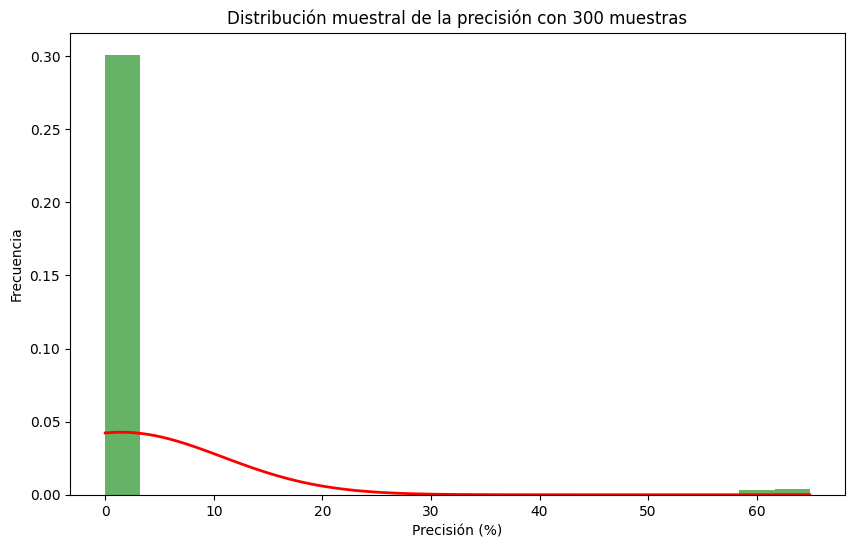

1.4412100456621004 9.328891778955349 0.0


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Calcular la media y la desviación estándar de las muestras
mu, std = np.mean(muestras), np.std(muestras)

# Generar la distribución gaussiana
gaussian = norm(loc=mu, scale=std)

# Crear un array de valores x para la gráfica
x = np.linspace(min(muestras), max(muestras), 100)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.hist(muestras, bins=20, density=True, alpha=0.6, color='g')
plt.plot(x, gaussian.pdf(x), 'r', linewidth=2)
plt.title('Distribución de las predicciones y la gaussiana')
plt.xlabel('Precisión (%)')
plt.ylabel('Frecuencia')
plt.title('Distribución muestral de la precisión con 300 muestras')
plt.show()
print(mu, std, np.median(muestras))

In [37]:
# Definimos el modelo
model = Sequential()

# Añadir la capa de entrada y la primera capa oculta
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# Añadir la segunda capa oculta
# model.add(Dense(units=32, activation='tanh'))

# Añadir la capa de salida
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
56/56 [==============================] - 1s 5ms/step - loss: 0.6763 - accuracy: 0.5840 - val_loss: 0.6568 - val_accuracy: 0.6248
Epoch 2/10
56/56 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6801 - val_loss: 0.6388 - val_accuracy: 0.6281
Epoch 3/10
56/56 [==============================] - 0s 3ms/step - loss: 0.6053 - accuracy: 0.7102 - val_loss: 0.6336 - val_accuracy: 0.6382
Epoch 4/10
56/56 [==============================] - 0s 3ms/step - loss: 0.5772 - accuracy: 0.7275 - val_loss: 0.6375 - val_accuracy: 0.6231
Epoch 5/10
56/56 [==============================] - 0s 3ms/step - loss: 0.5491 - accuracy: 0.7499 - val_loss: 0.6443 - val_accuracy: 0.6415
Epoch 6/10
56/56 [==============================] - 0s 3ms/step - loss: 0.5230 - accuracy: 0.7610 - val_loss: 0.6521 - val_accuracy: 0.6298
Epoch 7/10
56/56 [==============================] - 0s 2ms/step - loss: 0.4965 - accuracy: 0.7772 - val_loss: 0.6729 - val_accuracy: 0.6298
Epoch 8/10
56/56 [==

In [38]:
X_test = X_test.astype('float64')
y_test = y_test.astype('float64')

In [39]:
# Hacemos la predicción
prediccion_test = model.predict(X_test)
predicciones = [1 if p > 0.5 else 0 for p in prediccion_test]
print(prediccion_test)


19/19 [==============================] - 0s 901us/step
[[0.29038915]
 [0.87870055]
 [0.54795855]
 [0.5245315 ]
 [0.5045618 ]
 [0.36112508]
 [0.7144016 ]
 [0.03337231]
 [0.3889252 ]
 [0.9699946 ]
 [0.5099    ]
 [0.36921182]
 [0.7297144 ]
 [0.63629687]
 [0.68620294]
 [0.6169642 ]
 [0.39685398]
 [0.5028087 ]
 [0.10143806]
 [0.58792716]
 [0.8212631 ]
 [0.2250678 ]
 [0.71199334]
 [0.15303053]
 [0.5367422 ]
 [0.91462004]
 [0.8508729 ]
 [0.45524526]
 [0.48863417]
 [0.9108071 ]
 [0.06258722]
 [0.46039274]
 [0.7530577 ]
 [0.02825113]
 [0.12024859]
 [0.33825666]
 [0.376912  ]
 [0.87311417]
 [0.48498312]
 [0.7625294 ]
 [0.30032316]
 [0.3838249 ]
 [0.34591183]
 [0.19031383]
 [0.59378695]
 [0.04645526]
 [0.9004796 ]
 [0.7963751 ]
 [0.88856345]
 [0.43073097]
 [0.5097691 ]
 [0.54992664]
 [0.79999274]
 [0.29630464]
 [0.32808307]
 [0.94191605]
 [0.58851147]
 [0.7145085 ]
 [0.38261363]
 [0.34937716]
 [0.15770598]
 [0.63163024]
 [0.8566286 ]
 [0.3422166 ]
 [0.37031204]
 [0.81734854]
 [0.30386424]
 [0.633

In [40]:
# Filtrar valores mayores que 0.7 o menores que 0.3
valores_filtrados = [1 if p > 0.80 else (0 if p < 0.20 else -1) for p in prediccion_test]

print(valores_filtrados)



[-1, 1, -1, -1, -1, -1, -1, 0, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 1, -1, -1, 0, -1, 1, 1, -1, -1, 1, 0, -1, -1, 0, 0, -1, -1, 1, -1, -1, -1, -1, -1, 0, -1, 0, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 0, -1, 1, -1, -1, 1, -1, -1, -1, 0, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, 0, -1, -1, -1, 1, 0, -1, -1, 0, -1, -1, 0, -1, 1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 0, 1, -1, -1, -1, -1, -1, -1, 1, 0, -1, -1, 0, -1, 1, 0, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 0, 0, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 0, -1, -1, 1, -1, -1, -1, -1, 0, -1, -1, 0, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 0, -1, 0, 0, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 0, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 0, 1, -1, 1, -1, -1, 

In [41]:
print(y_test)

[1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1.
 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1.

In [42]:
# Veamos cuántos partidos ha acertado para el test
aciertos = 0
for i in range(len(predicciones)):
    if predicciones[i] == y_test[i]:
        aciertos += 1
print(f"Precisión del test: {np.round(aciertos / len(predicciones)*100, 2)}%")

Precisión del test: 59.7%


In [43]:
# Veamos cuántos partidos ha acertado para el test
aciertos = 0
n = 0
indices = list()
for i in range(len(valores_filtrados)):
    if valores_filtrados[i] != -1:
        n += 1
        indices.append(i)
        if valores_filtrados[i] == y_test[i]:
            aciertos += 1
print(f"Precisión del test: {np.round(aciertos / n*100, 2)}% para el {np.round(n/len(y_test)*100, 2)}% de partidos")
print(indices)

Precisión del test: 65.95% para el 30.94% de partidos
[1, 7, 9, 18, 20, 23, 25, 26, 29, 30, 33, 34, 37, 43, 45, 46, 48, 55, 60, 62, 65, 69, 70, 71, 72, 74, 76, 86, 87, 94, 99, 103, 104, 107, 110, 112, 118, 126, 127, 134, 135, 138, 140, 141, 145, 152, 156, 157, 161, 171, 173, 176, 181, 184, 186, 192, 197, 199, 200, 202, 203, 211, 213, 216, 223, 225, 238, 245, 253, 259, 262, 263, 265, 278, 279, 280, 293, 298, 302, 304, 307, 309, 310, 315, 321, 323, 324, 326, 328, 330, 331, 334, 336, 338, 339, 340, 343, 344, 347, 348, 349, 350, 353, 354, 355, 357, 359, 365, 369, 371, 374, 383, 384, 385, 391, 392, 396, 400, 402, 408, 410, 415, 417, 423, 425, 428, 429, 431, 437, 438, 440, 445, 446, 450, 451, 452, 456, 459, 461, 462, 465, 466, 467, 469, 470, 472, 481, 483, 487, 488, 491, 492, 501, 503, 512, 517, 522, 524, 533, 535, 537, 538, 539, 540, 542, 545, 547, 552, 558, 560, 565, 567, 570, 571, 573, 576, 579, 580, 581, 583, 586, 589, 592, 595, 596]
